# Customer Segmentation for Targeted Marketing

This notebook performs customer segmentation using K-Prototypes clustering based on demographic, behavioral, and transactional data. This analysis combines customer infomation, transactions, delivery, and engagement metrics to uncover patterns in customer behavior. The goal is to support targeted marketing, optimize loyalty program strategies, and strengthen customer retention efforts.

## Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from kneed import KneeLocator

## Load Dataset

In [2]:
data = pd.read_csv('sales.csv')
df = pd.DataFrame(data)

df.head()

,user_id,age,sex,phone_number,joined_date,country,payment_method,loyalty_program_member,loyalty_points_redeemed,loyalty_tier,...,return_date,order_id,released_date,estimated_delivery_date,received_date,total_delivery_days,shipping_method,shipping_cost,tracking_number,customer_exp_rating
0,****980545,22,M,63**409216**,2023-02-14,Philippines,maya,1,1,2.0,...,NaN,***621668,2024-04-03,2024-04-07,2024-04-07,8,standard,203,***5E7HOXAW93,3
1,****906406,23,M,63**369756**,2024-04-19,Philippines,visa_c,0,0,NaN,...,NaN,***002517,2024-04-26,2024-05-03,2024-05-04,6,standard,291,***R5NLL0ARWI,1
2,****860958,19,F,63**558004**,2023-03-03,Philippines,gcash,0,0,NaN,...,NaN,***050582,2024-01-28,2024-01-31,2024-02-01,11,standard,74,***EOVA6EJ4QO,1
3,****845150,58,O,63**783910**,2024-04-18,Philippines,otc,0,0,NaN,...,NaN,***110492,2024-06-09,2024-06-15,2024-06-13,8,express,82,***WKCU4XAR9B,1
4,****664897,37,O,63**600892**,2021-09-29,Philippines,visa_d,0,0,NaN,...,NaN,***201483,2022-07-08,2022-07-12,2022-07-09,14,standard,51,***5DEMJF3UCZ,5


## Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382423 entries, 0 to 382422
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        382423 non-null  object 
 1   age                            382423 non-null  int64  
 2   sex                            382423 non-null  object 
 3   phone_number                   382423 non-null  object 
 4   joined_date                    382423 non-null  object 
 5   country                        382423 non-null  object 
 6   payment_method                 382423 non-null  object 
 7   loyalty_program_member         382423 non-null  int64  
 8   loyalty_points_redeemed        382423 non-null  int64  
 9   loyalty_tier                   191126 non-null  float64
 10  tier_discount_percentage       191126 non-null  float64
 11  card_discount_percentage       88589 non-null   float64
 12  coupon_discount_percentage    

In [4]:
df.describe()

,age,loyalty_program_member,loyalty_points_redeemed,loyalty_tier,tier_discount_percentage,card_discount_percentage,coupon_discount_percentage,total_discount_percentage,total_purchase,total_discount,total_purchase_after_discount,refund_amount,return_date,total_delivery_days,shipping_cost,customer_exp_rating
count,382423.000000,382423.000000,382423.000000,191126.000000,191126.000000,88589.000000,382423.000000,382423.000000,382423.000000,382423.000000,382423.000000,382423.0,0.0,382423.000000,382423.000000,382423.000000
mean,38.972808,0.499776,2.259464,2.501753,6.254419,2.993634,2.500265,6.319557,5030.485462,317.719726,4712.765736,0.0,NaN,7.491717,175.037330,3.002795
std,12.390457,0.500001,3.031826,1.118606,2.587818,1.414830,1.706888,4.258269,2871.789926,305.853472,2702.065875,0.0,NaN,3.302425,72.496094,1.414959
min,18.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,50.000000,0.000000,42.120000,0.0,NaN,-1.000000,50.000000,1.000000
25%,28.000000,0.000000,0.000000,2.000000,5.000000,2.000000,1.000000,3.000000,2543.000000,80.400000,2376.900000,0.0,NaN,5.000000,112.000000,2.000000
50%,39.000000,0.000000,0.000000,3.000000,7.000000,3.000000,2.000000,5.000000,5037.000000,226.200000,4706.300000,0.0,NaN,7.000000,175.000000,3.000000
75%,50.000000,1.000000,5.000000,4.000000,10.000000,4.000000,4.000000,9.000000,7517.000000,464.800000,7023.350000,0.0,NaN,10.000000,238.000000,4.000000
max,60.000000,1.000000,9.000000,4.000000,10.000000,5.000000,5.000000,20.000000,9999.000000,1997.000000,9999.000000,0.0,NaN,16.000000,300.000000,5.000000


In [5]:
df.columns

Index(['user_id', 'age', 'sex', 'phone_number', 'joined_date', 'country',
       'payment_method', 'loyalty_program_member', 'loyalty_points_redeemed',
       'loyalty_tier', 'tier_discount_percentage', 'card_discount_percentage',
       'coupon_discount_percentage', 'total_discount_percentage',
       'total_purchase', 'total_discount', 'total_purchase_after_discount',
       'transaction_id', 'payment_status', 'payment_date', 'payment_time',
       'purchased_date', 'purchased_time', 'product_category',
       'purchase_medium', 'return_status', 'refund_amount', 'return_date',
       'order_id', 'released_date', 'estimated_delivery_date', 'received_date',
       'total_delivery_days', 'shipping_method', 'shipping_cost',
       'tracking_number', 'customer_exp_rating'],
      dtype='object')

In [6]:
df.isnull().sum()

user_id                               0
age                                   0
sex                                   0
phone_number                          0
joined_date                           0
country                               0
payment_method                        0
loyalty_program_member                0
loyalty_points_redeemed               0
loyalty_tier                     191297
tier_discount_percentage         191297
card_discount_percentage         293834
coupon_discount_percentage            0
total_discount_percentage             0
total_purchase                        0
total_discount                        0
total_purchase_after_discount         0
transaction_id                        0
payment_status                        0
payment_date                          0
payment_time                          0
purchased_date                        0
purchased_time                        0
product_category                      0
purchase_medium                       0


In [7]:
categoricalFeatures = [
    'user_id', 'sex', 'phone_number', 'joined_date', 'country',
    'payment_method', 'transaction_id', 'payment_status', 'payment_date',
    'payment_time', 'purchased_date', 'purchased_time', 'product_category',
    'purchase_medium', 'return_status', 'return_date', 'order_id',
    'released_date', 'estimated_delivery_date', 'received_date', 
    'shipping_method', 'tracking_number'
]

numericalFeatures = [
    'age', 'loyalty_program_member', 'loyalty_points_redeemed', 'loyalty_tier',
    'tier_discount_percentage', 'card_discount_percentage', 'coupon_discount_percentage',
    'total_discount_percentage', 'total_purchase', 'total_discount',
    'total_purchase_after_discount', 'refund_amount', 'total_delivery_days',
    'shipping_cost', 'customer_exp_rating'
]

## Preprocessing

In [8]:
df['loyalty_tier'] = df['loyalty_tier'].fillna(np.nan).astype(str)

In [9]:
df['purchased_date'] = pd.to_datetime(df['purchased_date'])
reference_date = df['purchased_date'].max()
df['recency_days'] = (reference_date - df['purchased_date']).dt.days
df['recency_score'] = df['recency_days'].max() - df['recency_days']

numericalFeatures.append('recency_days')

In [10]:
for col in categoricalFeatures:
    print(df[col].value_counts(normalize=True))

user_id
****299535    0.000016
****548188    0.000016
****967186    0.000016
****560695    0.000016
****118083    0.000016
                ...   
****131327    0.000003
****600145    0.000003
****543424    0.000003
****954227    0.000003
****220899    0.000003
Name: proportion, Length: 317621, dtype: float64
sex
F    0.334527
O    0.333876
M    0.331596
Name: proportion, dtype: float64
phone_number
63**587182**    0.000024
63**508917**    0.000021
63**871062**    0.000021
63**276069**    0.000021
63**476762**    0.000021
                  ...   
63**392853**    0.000003
63**085250**    0.000003
63**414941**    0.000003
63**560803**    0.000003
63**625654**    0.000003
Name: proportion, Length: 271838, dtype: float64
joined_date
2020-08-21    0.000719
2020-08-27    0.000706
2020-03-14    0.000693
2022-12-07    0.000677
2023-03-01    0.000664
                ...   
2024-01-01    0.000434
2021-07-26    0.000431
2024-07-07    0.000429
2022-06-18    0.000413
2022-03-13    0.000397
Name: pro

## Drop Irrelevant Columns
- Drop unique IDs, constant columns, or irrelevant info to simplify clustering

In [11]:
df.drop([
    'transaction_id', 'order_id', 'tracking_number', 'phone_number', 'country', 
    'payment_status', 'return_status', 'payment_date', 'payment_time', 
    'released_date', 'estimated_delivery_date', 'received_date', 'refund_amount',
    'joined_date','card_discount_percentage','purchased_date','purchased_time'
], axis=1, inplace=True)

In [12]:
categoricalFeatures = df.select_dtypes(include='object').columns.tolist()
numericalFeatures = df.select_dtypes(include = ['int64','float64']).columns.tolist()

## Aggregate Data by User
- Aggregation to reduce duplicate information (multiple purchases from the same customer)

In [13]:
custAgg = df.groupby('user_id').agg({
    'age': 'first',
    'sex': 'first',
    'loyalty_program_member': 'first',
    'loyalty_tier': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'coupon_discount_percentage': 'mean',
    'total_discount_percentage': 'mean',
    'total_purchase': 'sum',
    'customer_exp_rating': 'mean',
    'product_category': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'purchase_medium': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'total_delivery_days': 'mean',
    'shipping_method': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'shipping_cost': 'mean',
    'recency_score': 'mean',
}).reset_index()

In [14]:
categoricalFeatures = ['sex','loyalty_program_member', 'loyalty_tier', 
                       'product_category', 'purchase_medium', 'shipping_method']

numericalFeatures = ['age', 'tier_discount_percentage', 'coupon_discount_percentage',
                     'total_discount_percentage', 'total_purchase_after_discount', 'customer_exp_rating',
                     'total_delivery_days','recency_score']

## Finding Optimal K
- Utilized a sample of the dataset to speed up processes

In [15]:
custAggSample = custAgg.sample(n=2000, random_state=42).drop(columns = ['user_id'])

sampleIndices = [custAggSample.columns.get_loc(col) for col in custAggSample.select_dtypes(include='object').columns]
sampleMatrix = custAggSample.to_numpy()

### Elbow Method to Determine Optimal K

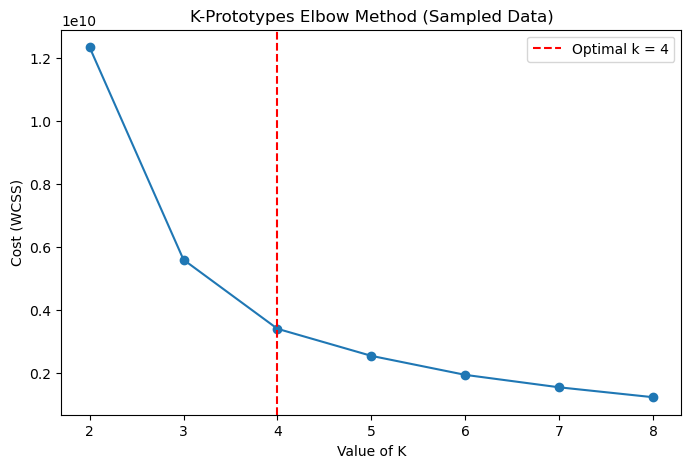

In [16]:
possibleK = list(range(2,9))
wcss = []

for k in possibleK:
    kproto = KPrototypes(n_clusters = k, init = 'Huang', verbose = 0, max_iter = 15, random_state = 42)
    kproto.fit_predict(sampleMatrix, categorical = sampleIndices)
    wcss.append(kproto.cost_)

kneeLocator = KneeLocator(possibleK, wcss, curve='convex', direction='decreasing')
kValue = kneeLocator.elbow

plt.figure(figsize=(8, 5))
plt.plot(possibleK, wcss, marker = 'o')
plt.axvline(x = kValue, color = 'red', linestyle='--', label = f'Optimal k = {kValue}')
plt.title('K-Prototypes Elbow Method (Sampled Data)')
plt.xlabel('Value of K')
plt.ylabel('Cost (WCSS)')
plt.legend()
plt.show()

## Apply K-Prototypes to the sample data

In [17]:
kProtoSample = KPrototypes(n_clusters = kValue, init = 'Huang', gamma = 0.5, verbose = 1, random_state = 42)
clustersSample = kProtoSample.fit_predict(sampleMatrix, categorical = sampleIndices)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 427, ncost: 3486817650.52378
Run: 1, iteration: 2/100, moves: 93, ncost: 3431061807.654023
Run: 1, iteration: 3/100, moves: 55, ncost: 3412282842.2122574
Run: 1, iteration: 4/100, moves: 31, ncost: 3405257115.434912
Run: 1, iteration: 5/100, moves: 17, ncost: 3403068148.6873326
Run: 1, iteration: 6/100, moves: 10, ncost: 3401718459.246753
Run: 1, iteration: 7/100, moves: 5, ncost: 3401445349.0166674
Run: 1, iteration: 8/100, moves: 1, ncost: 3401434833.0772133
Run: 1, iteration: 9/100, moves: 0, ncost: 3401434833.0772133
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 568, ncost: 5755665116.174164
Run: 2, iteration: 2/100, moves: 343, ncost: 3905629171.098614
Run: 2, iteration: 3/100, moves: 148, ncost: 3518215865.539331
Run: 2, iteration: 4/100, moves: 96, ncost: 3446214711.1803637
Run: 2, iteration: 5/100, mo

## Grid Search for Hyperparameter Tuning

In [18]:
def gridsearch(matrix, index, k, methods, gamma):
    try:
        kproto = KPrototypes(n_clusters = k, init = methods, gamma = gamma, 
                             max_iter = 15, n_init = 3, verbose = 0, random_state = 42)
        clusters = kproto.fit_predict(matrix, categorical = index)
        return {'k': k, 'method': methods, 'gamma': gamma, 'cost': kproto.cost_,
                'labels': clusters, 'model': kproto}
    except Exception as e:
        return {'k': k, 'method': methods, 'gamma': gamma, 'error': str(e)}

In [19]:
methods = ['Huang', 'Cao']
gammas = [0.1, 0.5, 1.0, 2.0]

results = []

for method in methods:
    for gamma in gammas:
        print(f"k = 4, init = {method}, gamma = {gamma}")
        result = gridsearch(sampleMatrix, sampleIndices, 4, method, gamma)
        results.append(result)

successful = [result for result in results if 'error' not in result]

if not successful:
    print("Unsuccessful")
else:
    best = min(successful, key=lambda x: x['cost'])
    print("\nBest Result for k = 4")
    print(f"Method: {best['method']}")
    print(f"Gamma: {best['gamma']}")
    print(f"Cost: {best['cost']:.2f}")

k = 4, init = Huang, gamma = 0.1
k = 4, init = Huang, gamma = 0.5
k = 4, init = Huang, gamma = 1.0
k = 4, init = Huang, gamma = 2.0
k = 4, init = Cao, gamma = 0.1
k = 4, init = Cao, gamma = 0.5
k = 4, init = Cao, gamma = 1.0
k = 4, init = Cao, gamma = 2.0

Best Result for k = 4
Method: Huang
Gamma: 0.1
Cost: 3401293707.13


## Apply Best Hyperparameters to Full Dataset

In [20]:
fullData = custAgg[custAgg.columns.tolist()].copy().drop(columns = ['user_id'])
fullDataIndices = [fullData.columns.get_loc(col) for col in fullData.select_dtypes(include='object').columns]
fullMatrix = fullData.to_numpy()

custAgg['cluster'] = best['model'].predict(fullMatrix, categorical = fullDataIndices)

## Aggregate Clustered Dataset
- Summarize clusters to understand customer groups

In [21]:
custAggClustered = custAgg.groupby('cluster').agg({
    'age': 'mean',
    'sex': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'loyalty_program_member': 'mean',
    'loyalty_tier': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'coupon_discount_percentage': 'mean',
    'total_discount_percentage': 'mean',
    'total_purchase': 'sum',
    'customer_exp_rating': 'mean',
    'product_category': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'purchase_medium': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'total_delivery_days': 'mean',
    'shipping_method': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'shipping_cost': 'mean',
    'recency_score': 'mean',
    'user_id': 'count' 
}).rename(columns={'user_id': 'cluster_count'}).reset_index()

In [22]:
format = ['age', 'coupon_discount_percentage', 'total_discount_percentage', 'total_purchase',
                  'customer_exp_rating', 'total_delivery_days', 'shipping_cost','recency_score']

for col in format:
    custAggClustered[col] = custAggClustered[col].apply(lambda x: f"{x:.2f}")

In [23]:
custAggClustered

,cluster,age,sex,loyalty_program_member,loyalty_tier,coupon_discount_percentage,total_discount_percentage,total_purchase,customer_exp_rating,product_category,purchase_medium,total_delivery_days,shipping_method,shipping_cost,recency_score,cluster_count
0,0,38.96,O,0.501188,nan,2.49,6.33,181611090.00,3.00,beauty,in-store,7.48,express,175.08,1362.74,97203
1,1,38.97,F,0.497928,nan,2.50,6.31,885295603.00,3.01,appliances,in-store,7.50,express,175.08,1361.93,100643
2,2,38.96,F,0.499276,nan,2.50,6.31,530720804.00,3.00,automotive,in-store,7.50,express,175.17,1360.41,98813
3,3,39.00,F,0.501002,nan,2.50,6.32,326145845.00,3.01,appliances,in-store,7.50,express,174.50,1365.00,20962
